In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime, os, glob, json, string, inspect, emcee
from scipy.stats import median_abs_deviation
from matplotlib.patches import Circle, Ellipse
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from astropy.io import ascii, fits
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy.table import Table
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

## Solve for absolute offsets using known VLBA calibrators

In [2]:
np.set_printoptions(precision=20)

# Change from  Astrogeo Text to Astropy.coordinate format
def change_text(ra, dec):
    ra  = ra.replace(':','h',1).replace(':','m',1) + 's'
    dec = dec.replace(':','d',1).replace(':','m',1) + 's'

    return ra, dec

# Average while factoring in np.nan values
def NanAverage(data,err,weights=False,axis=0):
    '''
    (Weighted) Average that ignore nan values for an arbitrary axis
    '''
    
    # Ensure inputs are numpy arrays
    data = np.array(data)
    err  = np.array(err)
    
    if weights:
        
        # Mask NaNs
        ma = np.ma.MaskedArray(data, mask=np.isnan(data))
        avg = np.ma.average(ma, weights=1. / err ** 2, axis=axis)
        ma = np.ma.MaskedArray(err, mask=np.isnan(data))
        avg_err = np.ma.sum(ma ** (-2), axis=axis) ** (-0.5)
        
    else:
        avg = np.nanmean(data, axis=axis)
        avg_err = np.nansum(err ** 2, axis=axis) / len(err)
        
    return avg, avg_err

# Fit function
def stdfit(snr,A,B):
    '''
    Fit function to quantify the (relative) astrometric precision:
        The parameter A is the signal-to-noise dependency
        The parameter B is the systematic limit (independant of signal-to-noise)
    '''
    return np.sqrt(A**2 / (snr**2) + B**2)


# Load in the beam extents; i.e., lengths along the RA and Dec directions per epoch
ra_extents, dec_extents = np.genfromtxt('../../analysis/meerkat/astrometry/beamextents.txt', skip_header=1).T
    
# These are conservative estimates from the MCMC fitting
A = 5.0e-1 
B = 2.0e-2

# Load in the file and image names and epoch corrections
files  = sorted(glob.glob('../../analysis/meerkat/astrometry/total_field_202*'))
ra_factors, ra_factor_errs = np.load('../../analysis/meerkat/astrometry/RA_epoch_corr_asec_SAXJ1810.npy')
dec_factors, dec_factor_errs = np.load('../../analysis/meerkat/astrometry/RA_epoch_corr_asec_SAXJ1810.npy')
bmajs, bmins, bpas = np.genfromtxt('../../analysis/meerkat/astrometry/beams.txt', skip_header=1).T

# List of VLBA calibrators from astrogeo
SourceRAs  = ['18:11:05.9115', # 0.44 deg sep
              '18:12:45.5798', # 0.53 
              '18:08:17.0815', # 0.60
              '18:07:40.68771451', # 1.25
              '18:13:52.7487', # 1.33
              '18:15:10.6270', # 1.46
              '18:05:23.5488', # 1.53
              '18:17:32.5443', # 1.74
              '18:11:20.1465'] # 1.84

SourceDecs = ['-26:35:15.841',
              '-25:52:37.795',
              '-25:55:07.443',
              '-25:06:25.9436088',
              '-27:17:06.033',
              '-27:13:03.768', # This source looks extended
              '-25:12:38.769',
              '-26:59:22.965',
              '-27:59:46.181'] 

ra_off      = []
dec_off     = []
ra_off_err  = []
dec_off_err = []

fluxes      = []
rms         = []
counts = np.zeros(len(SourceRAs))

# Iterate through files
for k in range(len(files)):
    
    # Initialize epoch variables
    file = files[k]
    
    ra_extent = ra_extents[k]
    dec_extent = dec_extents[k]
    
    ra_factor = ra_factors[k]
    ra_factor_err = ra_factor_errs[k]
    dec_factor = dec_factors[k]
    dec_factor_err = dec_factor_errs[k]
  
    # Beams 
    bmaj = bmajs[k]
    bmin = bmins[k]
    
    # Read in the PyBDSF file
    srl = fits.open(file)
    ras       = srl[1].data['RA'] + 360.0
    decs      = srl[1].data['DEC']
    total     = srl[1].data['Total_flux']
    peaks     = srl[1].data['Peak_flux']
    peak_cen  = srl[1].data['Peak_flux_cen']
    isl       = srl[1].data['Isl_Total_flux']
    isl_rms   = srl[1].data['Isl_rms']
    major     = srl[1].data['Maj_img_plane'] * 3600.0          # Major Axis of the Source (deg)
    minor     = srl[1].data['Min_img_plane'] * 3600.0           # Minor Axis of the Source (deg)
    srl.close()
                
    # Look at the coordinates
    mkat_coord = SkyCoord(ra=ras*u.deg, dec=decs*u.deg) 

    ra_off_i      = []
    dec_off_i     = []
    ra_off_err_i  = []
    dec_off_err_i = []

    fluxes_i      = []
    rms_i         = []

    for z in range(len(SourceDecs)): 
        ref_ra, ref_dec = change_text(SourceRAs[z], SourceDecs[z])
        ref_coord = SkyCoord('{} {}'.format(ref_ra, ref_dec))
        seps = mkat_coord.separation(ref_coord).deg
        index = np.argmin(seps)  
        
        # Solve for condition parameters
        shape_threshold = 0.25 # 25% threshold same as astrometry routine
        snr_threshold = 10.0
        
        flux_ratio = abs(peaks[index]/isl[index] - 1.0)
        bmaj_ratio = abs(major[index]/bmaj - 1.0)
        bmin_ratio = abs(minor[index]/bmin - 1.0)
        snr = peaks[index]/isl_rms[index]
        
        if flux_ratio < shape_threshold and  bmaj_ratio < shape_threshold and  bmin_ratio < shape_threshold and  snr >= snr_threshold:
            
            # Offsets from known positions
            ra_off_i.append(ras[index] - ref_coord.ra.deg)
            dec_off_i.append(decs[index] - ref_coord.dec.deg)
            
            fluxes_i.append(peaks[index])
            rms_i.append(isl_rms[index])
            
            ra_off_err_i.append(ra_extent * stdfit(snr, A, B))
            dec_off_err_i.append(dec_extent * stdfit(snr, A, B))
            
            counts[z] += 1
        
        else:
            ra_off_i.append(np.nan)
            dec_off_i.append(np.nan)
            ra_off_err_i.append(np.nan)
            dec_off_err_i.append(np.nan)
            
            fluxes_i.append(np.nan)
            rms_i.append(np.nan)
           
    ra_off.append(ra_off_i)
    dec_off.append(dec_off_i)
    ra_off_err.append(ra_off_err_i)
    dec_off_err.append(dec_off_err_i)
    
    fluxes.append(fluxes_i)
    rms.append(rms_i)
        
print('Number of VLBA Sources that met point-like criteria = {}/{}'.format(len(np.where(counts != 0.0)[0]),len(SourceDecs)))
        
# Convert to numpy arrays
ra_off             = np.array(ra_off) * 3600.0  # This converts to arc seconds
dec_off            = np.array(dec_off) * 3600.0
ra_off_err         = np.array(ra_off_err) 
dec_off_err        = np.array(dec_off_err)

fluxes      = np.array(fluxes)
rms_u         = np.array(rms)

# Solve for the values after applying epoch to epoch corrections from relative astrometric fitting
ra_corr      = (ra_off.T - ra_factors).T
dec_corr     = (dec_off.T - dec_factors).T
ra_corr_err  = (np.sqrt(ra_off_err.T ** 2  + ra_factor_errs **2)).T
dec_corr_err = (np.sqrt(dec_off_err.T ** 2 + dec_factor_errs **2)).T

# Take the weighted mean of the offsets 
weighted = True
ra_mean_corr,  ra_err_mean_corr  = NanAverage(ra_corr,   ra_corr_err,  weights=weighted, axis= 1)
dec_mean_corr, dec_err_mean_corr = NanAverage(dec_corr,  dec_corr_err, weights=weighted, axis= 1)

# Take the weighted mean of the weighted means for a single time-independant correction
ra_global_corr,  ra_err_global_corr  = NanAverage(ra_mean_corr,    ra_err_mean_corr,  weights=weighted,  axis = 0)
dec_global_corr, dec_err_global_corr = NanAverage(dec_mean_corr,   dec_err_mean_corr,  weights=weighted, axis = 0)


Number of VLBA Sources that met point-like criteria = 8/9


## Solve for the Source Positional offsets

In [3]:
#################
# Load the Data #
#################

# Archival position
archival_position = SkyCoord("18h10m44.47s -26d09m01.2s", frame = 'icrs')
ra_0  = archival_position.ra.deg - 360.0
dec_0 = archival_position.dec.deg 

# Load in the data 
time_arr, _ = np.load('../../analysis/meerkat/results/imfit_times.npy')
source = np.load('../../analysis/meerkat/results/imfit_flux_results.npy')
time_arr = Time(time_arr, format='isot').mjd

# Solve for the offsets -- Without any absolute correction
ra_off      = (source[2] - ra_0) * 3600.0
ra_off_err  = ra_extents * stdfit(source[0]/source[1], A, B)
dec_off     = (source[3] - dec_0) * 3600.0 
dec_off_err = dec_extents* stdfit(source[0]/source[1], A, B)

# With absolute correction using calibrators + absolute "relative" offset
ra_global        = ra_off - ra_factors - ra_global_corr
ra_global_err    = np.sqrt(ra_off_err ** 2 + ra_err_global_corr ** 2 + ra_factor_errs ** 2)
dec_global       = dec_off - dec_factors - dec_global_corr
dec_global_err   = np.sqrt(dec_off_err ** 2 + dec_err_global_corr ** 2 + dec_factor_errs ** 2)

## Print the Average positions

In [15]:
right_acensions = source[2] - (ra_factors  - ra_global_corr) / 3600.0
declinations    = source[3] - (dec_factors - dec_global_corr) / 3600.0
ra_avg, ra_avg_err   = NanAverage(right_acensions, ra_global_err / 3600.0, weights=True)
dec_avg, dec_avg_err  = NanAverage(declinations, dec_global_err / 3600.0, weights=True)


print('Average Position')
print(SkyCoord(ra = ra_avg * u.deg, dec = dec_avg * u.deg).to_string('hmsdms'))
print('+/-', ra_avg_err * 3600.0, dec_avg_err * 3600.0, 'arcsec')

Average Position
18h10m44.32028176s -26d09m00.5458266s
+/- 0.093046401140639 0.1109961284661571 arcsec


## Plot the Positional Offsets

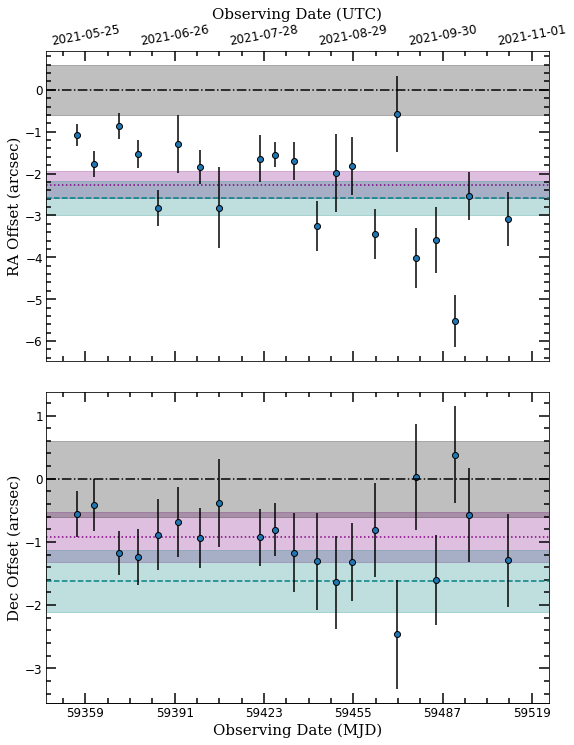

In [4]:
fig, ax = plt.subplots(2,figsize=(9,12), sharex='col', gridspec_kw={'hspace': 0.1})

# 2021 Outburst
ax[0].errorbar(Time(time_arr, format='mjd').datetime, ra_global, yerr= ra_global_err,  fmt='o', mec='k', color='C0', ecolor='k', zorder=1000)
ax[1].errorbar(Time(time_arr, format='mjd').datetime, dec_global, yerr= dec_global_err, fmt='o', mec='k', color='C0', ecolor='k',zorder=1000)

# 2023 Followup
ax[0].axhline(ra_global[-2], c='purple', ls=':')
ax[0].axhspan(ra_global[-2] - ra_global_err[-2], ra_global[-2] + ra_global_err[-2], color='purple', alpha=0.25)
ax[0].axhline(ra_global[-1], c='teal', ls='--')
ax[0].axhspan(ra_global[-1] - ra_global_err[-1], ra_global[-1] + ra_global_err[-1], color='teal', alpha=0.25)

ax[1].axhline(dec_global[-2], c='purple', ls=':')
ax[1].axhspan(dec_global[-2] - dec_global_err[-2], dec_global[-2] + dec_global_err[-2], color='purple', alpha=0.25)
ax[1].axhline(dec_global[-1], c='teal', ls='--')
ax[1].axhspan(dec_global[-1] - dec_global_err[-1], dec_global[-1] + dec_global_err[-1], color='teal', alpha=0.25)


# Archival position
ax[0].axhspan(-0.6, 0.6, color='k', alpha=0.25, zorder= 100)
ax[0].axhline(0.0, color='k', ls='-.', zorder= 2000)
ax[1].axhspan(-0.6, 0.6, color='k', alpha=0.25, zorder= 100)
ax[1].axhline(0.0, color='k', ls='-.', zorder= 2000)

ax[0].set_ylabel('RA Offset (arcsec)',  fontfamily='serif', fontsize=15)
ax[1].set_ylabel('Dec Offset (arcsec)', fontfamily='serif', fontsize=15)

# Make it Pretty
for ax_i in ax:
    #ax_i.xaxis.set_minor_locator(AutoMinorLocator(3))
    ax_i.tick_params(axis='both', which='minor', direction='in',length=5,width=1.5,top=True,right=True)
    ax_i.tick_params(axis='both', which='major', direction='in',length=10,width=1.5,top=True,right=True, labelsize=12, labelbottom=False)
    ax_i.minorticks_on()
    
def plot2mjd(t):
    '''Convert from matplotlib plot date to mjd'''
    return Time(t, format="plot_date", scale='utc').mjd


def mjd2plot(mjd):
    '''Convert from mjd to matplotlib plot'''
    return Time(mjd, format="mjd", scale='utc').plot_date

# Format primary x-axis
ax[0].set_xlabel('Observing Date (UTC)', fontsize=15, fontfamily='serif')    
ax[0].set_xlim(Time(59345, format='mjd').datetime,Time(59525, format='mjd').datetime)
ax[0].xaxis.set_major_locator(mdates.DayLocator(interval=32))
ax[0].xaxis.set_label_position('top') 
xformatter = mdates.DateFormatter('%Y-%m-%d')
plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)
ax[0].tick_params(axis='x', which='major',rotation=10, labelsize=12 ,labeltop=True, labelbottom=False)

# Format secondary x-axis
mjd_ax = ax[-1].secondary_xaxis('bottom', functions=(plot2mjd, mjd2plot))
mjd_ax.set_xlabel('Observing Date (MJD)', fontsize=15, fontfamily='serif')  
mjd_ax.tick_params(which='major', direction='in', length = 0.0, width = 0.0, labelsize=12)
plt.draw()

# Extract the labels
mjd_ticks = []
labels = ax[0].get_xticklabels(which='major')
for lab in labels:
    mjd_ticks.append(lab.get_text() + 'T00:00:00')

# Line up MJD and Datetime labels 
mjd_ticks = (Time(mjd_ticks, format='isot').mjd).astype(int)
mjd_ax.set_xticks(mjd_ticks, labels = mjd_ticks)
plt.show()


## Calculate the Chi-squared Statistics for the Best Fit Position. 

In [5]:
# Chi square calculations.
diff = (ra_global)
err  = np.sqrt(ra_global_err ** 2 + 0.6 ** 2)
chi2 = np.sum((diff/err) ** 2)
dof  = len(ra_mean_corr) - 1
redchi2 = chi2/dof
sig = np.sqrt(2 * dof) / dof
print('For RA the position is consistent with the archival pos at a chi^2/dof value of {:.1f}/{:.0f}  ~ {:.2f} +/- {:.2f}:'.format(chi2, dof, redchi2, sig))

diff = (dec_global)
err  = np.sqrt(dec_global_err ** 2 + 0.6 ** 2)
chi2 = np.sum((diff/err) ** 2)
dof  = len(dec_mean_corr) - 1
redchi2 = chi2/dof
sig = np.sqrt(2 * dof) / dof
print('For Dec the position is consistent with the archival pos at a chi^2/dof value of {:.1f}/{:.0f}  ~ {:.2f} +/- {:.2f}:'.format(chi2, dof, redchi2, sig))

# Compare to the average
avg, avg_err = NanAverage(ra_global,ra_global_err,weights=True,axis=0)
diff = (ra_global - avg)
err  = np.sqrt(ra_global_err ** 2 + avg_err ** 2)
chi2 = np.sum((diff/err) ** 2)
dof  = len(ra_mean_corr) - 1
redchi2 = chi2/dof
sig = np.sqrt(2 * dof) / dof
print('\nFor RA the position is consistent with the average pos at a chi^2/dof value of {:.1f}/{:.0f}  ~ {:.2f} +/- {:.2f}:'.format(chi2, dof, redchi2, sig))

avg, avg_err = NanAverage(dec_global,dec_global_err,weights=True,axis=0)
diff = (dec_global - avg)
err  = np.sqrt(dec_global_err ** 2 + avg_err ** 2)
chi2 = np.sum((diff/err) ** 2)
dof  = len(dec_mean_corr) - 1
redchi2 = chi2/dof
sig = np.sqrt(2 * dof) / dof
print('For Dec the position is consistent with the average pos at a chi^2/dof value of {:.1f}/{:.0f}  ~ {:.2f} +/- {:.2f}:'.format(chi2, dof, redchi2, sig))

# Compare RA to linear motion
linear = np.polyfit(time_arr, ra_global, deg = 1, w = 1. / ra_global_err)
diff = (ra_global - (time_arr * linear[0] + linear[1]))
err  = ra_global_err
chi2 = np.sum((diff/err) ** 2)
dof  = len(dec_mean_corr) - 1
redchi2 = chi2/dof
sig = np.sqrt(2 * dof) / dof
print('\nFor RA the position is consistent with the linear motion at a chi^2/dof value of {:.1f}/{:.0f}  ~ {:.2f} +/- {:.2f}:'.format(chi2, dof, redchi2, sig))


For RA the position is consistent with the archival pos at a chi^2/dof value of 216.3/22  ~ 9.83 +/- 0.30:
For Dec the position is consistent with the archival pos at a chi^2/dof value of 39.4/22  ~ 1.79 +/- 0.30:

For RA the position is consistent with the average pos at a chi^2/dof value of 96.6/22  ~ 4.39 +/- 0.30:
For Dec the position is consistent with the average pos at a chi^2/dof value of 16.4/22  ~ 0.75 +/- 0.30:

For RA the position is consistent with the linear motion at a chi^2/dof value of 92.1/22  ~ 4.19 +/- 0.30:
